This notebook will be used to look at plots from the nowcast_green runs

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

%matplotlib inline

In [2]:
# This is a copy of the viz_tools function for making this demo more self-contained.  

def set_aspect(
    axes,
    aspect=5/4.4,
    coords='grid',
    lats=None,
    adjustable='box-forced',
):
    """Set the aspect ratio for the axes.

    This is a thin wrapper on the :py:meth:`matplotlib.axes.Axes.set_aspect`
    method.
    Its primary purpose is to free the user from needing to remember the
    5/4.4 nominal aspect ratio for the Salish Sea NEMO model grid,
    and the formula for the aspect ratio based on latitude for map
    coordinates.
    It also sets the axes aspect ratio with :py:attr:`adjustable='box-forced'`
    so that the axes can be shared if desired.

    :arg axes: Axes instance to set the aspect ratio of.
    :type axes: :py:class:`matplotlib.axes.Axes`

    :arg aspect: Aspect ratio.
    :type aspect: float

    :arg coords: Type of plot coordinates to set the aspect ratio for;
                 either :kbd:`grid` (the default) or :kbd:`map`.
    :type coords: str

    :arg lats: Array of latitude values to calculate the aspect ratio
                    from; only required when :kbd:`coordinates='map'`.
    :type lats: :py:class:`numpy.ndarray`

    :arg adjustable: How to adjust the axes box.
    :type adjustable: str

    :returns: Aspect ratio.
    :rtype: float

    .. note::

        To explicitly set the aspect ratio for map coordinates
        (instead of calculating it from latitudes)
        set :kbd:`aspect` to the aspect ratio,
        :kbd:`coords='map'`,
        and use the default :kbd:`lats=None`.
    """
    if coords == 'map' and lats is not None:
        aspect = 1 / np.cos(np.median(lats) * np.pi / 180)
    axes.set_aspect(aspect, adjustable=adjustable)
    return aspect

Loading nowcast_green results

In [3]:
filename = 'SalishSea_1d_20151227_20151227_ptrc_T.nc'
grid_g = nc.Dataset(filename)
thalweg = np.loadtxt('thalweg_working.txt', dtype=int, unpack=True)

In [4]:
vnames=grid_g.variables.keys()
print(vnames)
excluded={'nav_lat', 'nav_lon', 'deptht', 'time_centered', 'time_centered_bounds','deptht_bounds',
          'time_counter','time_counter_bounds'}
vnames=[x for x in vnames if x not in excluded]
print(vnames)

odict_keys(['nav_lat', 'nav_lon', 'deptht', 'deptht_bounds', 'NO3', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'NH4', 'Si', 'PHY2', 'PHY', 'MYRI', 'MICZ', 'DOC', 'POC', 'bSi', 'O2'])
['NO3', 'NH4', 'Si', 'PHY2', 'PHY', 'MYRI', 'MICZ', 'DOC', 'POC', 'bSi', 'O2']


Pre-load and set some variable

In [5]:
zlevels = grid_g.variables['deptht'][:]
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)

## Make surface and thalweg plots for all fields

In [6]:
def plot_surface_thalweg(grid_g, thalweg, x, z, field):
    """ """
    
    conc = grid_g.variables[field]
    
    #Prepare surface values
    conc_ma = np.ma.masked_values(conc[0, 0, :, :], 0)
    # use tmask (meshmask file) instead
    vmin = np.min(conc_ma)
    vmax = np.max(conc_ma)
   
    #Prepare thalweg values
    npconc = conc[:]
    conc_t = npconc[0, :, thalweg[0], thalweg[1]]
    conc_t_ma = np.ma.masked_values(conc_t, 0)
    vmin_t = np.min(conc_t_ma)
    vmax_t = np.max(conc_t_ma)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    land_colour = 'burlywood'
    for ax in (ax2, ax1):
        ax.set_axis_bgcolor(land_colour)
    ax1.set_position((0.125, 0.125, 0.5, 0.775))
    #axcb.set_position((0.73, 0.125, 0.02, 0.775))
    ax2.set_position((0.8, 0.125, 0.2, 0.775))
    
    set_aspect(ax2)
    cmap = plt.get_cmap('Greens')
    cmap.set_bad('burlywood')
    
    #Surface plot
    mesh = ax2.pcolormesh(conc_ma, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mesh, ax=ax2)
    #plt.axis(0, conc_ma.shape[1], 0, conc_ma.shape[0])
    ax2.set_title('Surface {label}'.format(label=conc.long_name.title()), fontsize=16)
    ax2.set_xlabel('x Index')
    ax2.set_ylabel('y Index')
    cbar.set_label('{label} [{units}]'.format(label=conc.long_name.title(), units=conc.units))
    
    #Thalweg
    mesh = ax1.pcolormesh(x, z, conc_t_ma.T, cmap=cmap, vmin=vmin_t, vmax=vmax_t)
    ax1.invert_yaxis()
    ax1.set_xlim(0, thalweg[0][-1])
    ax1.set_title('{label} along Thalweg'.format(label=conc.long_name.title()), fontsize=16)
    ax1.set_xlabel('x Index', fontsize=14)
    ax1.set_ylabel('Depth (m)', fontsize=14)
    return fig

1 loops, best of 1: 2.48 s per loop


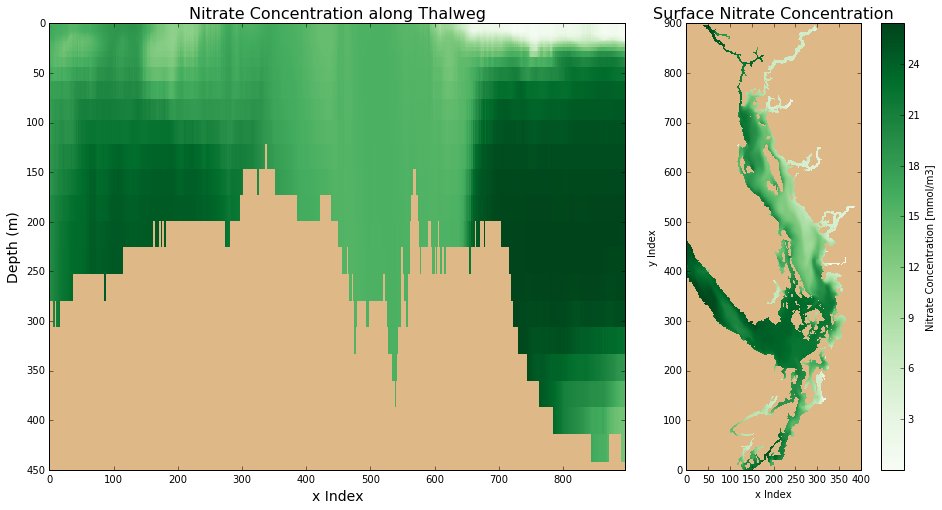

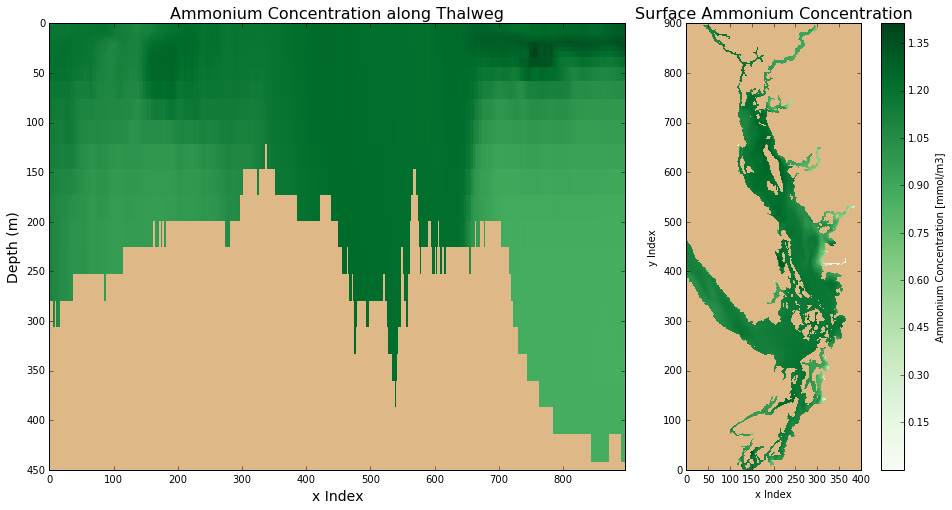

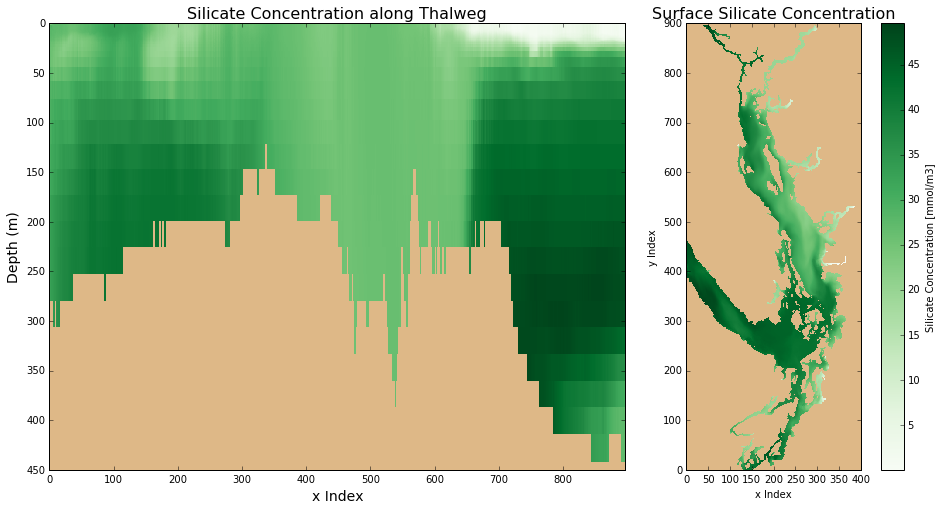

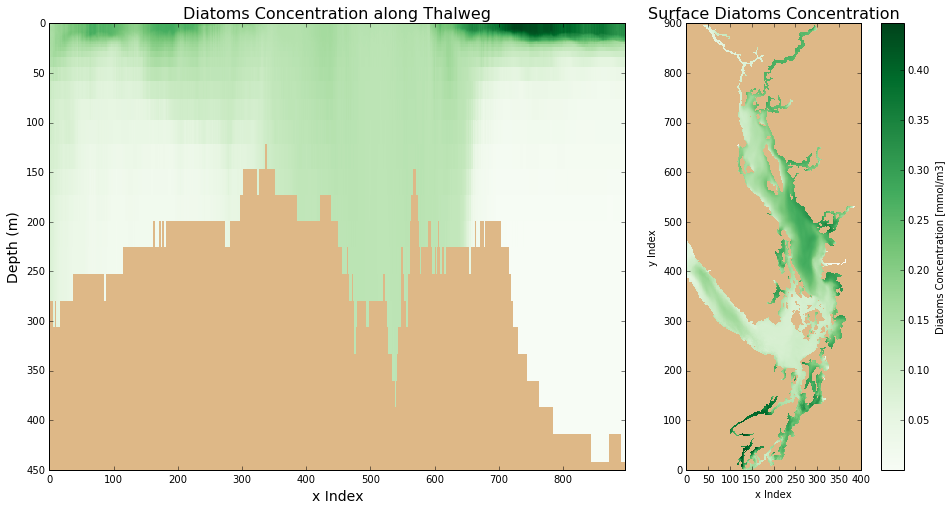

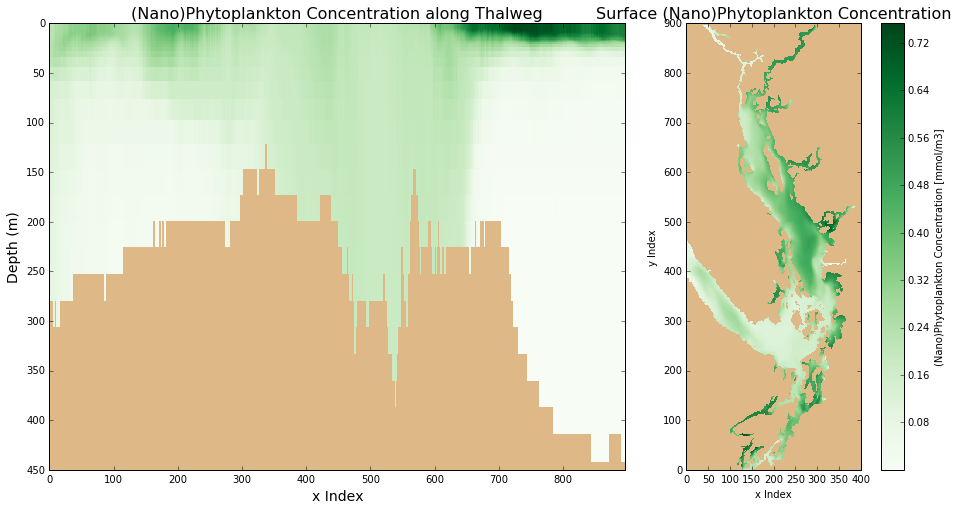

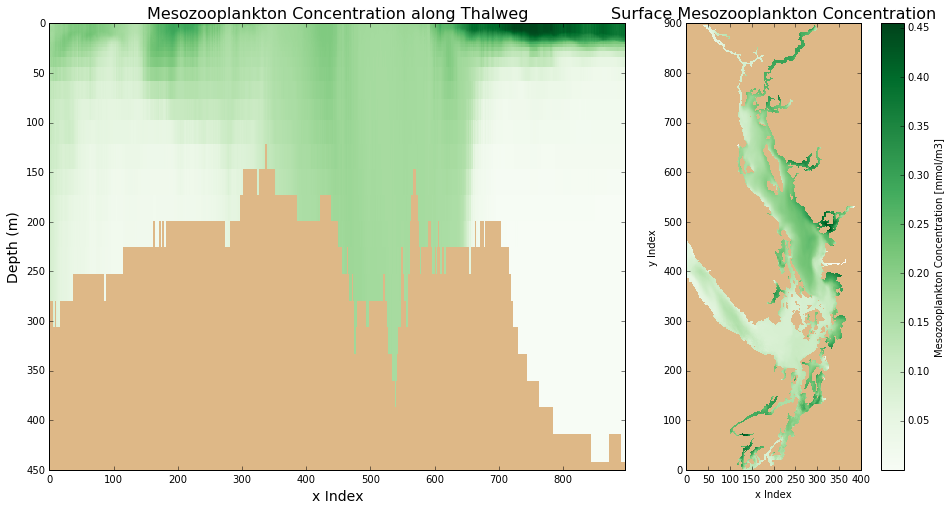

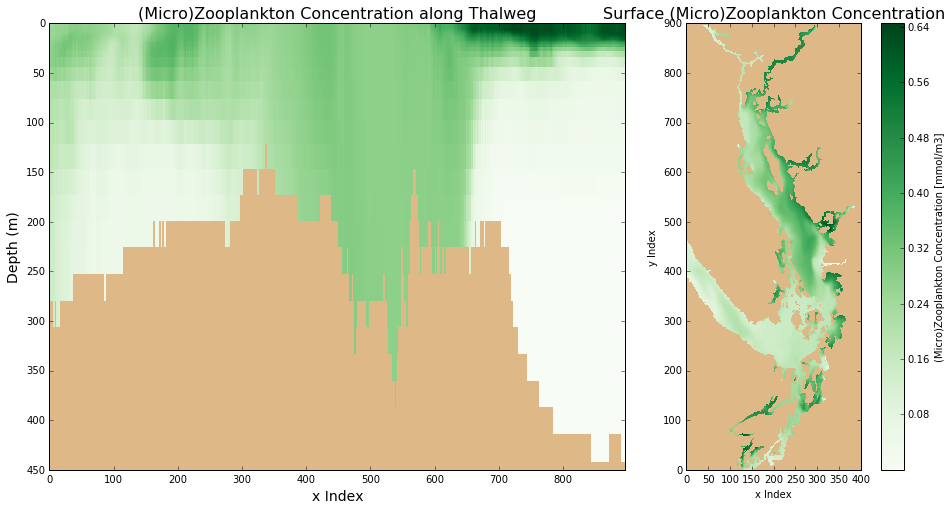

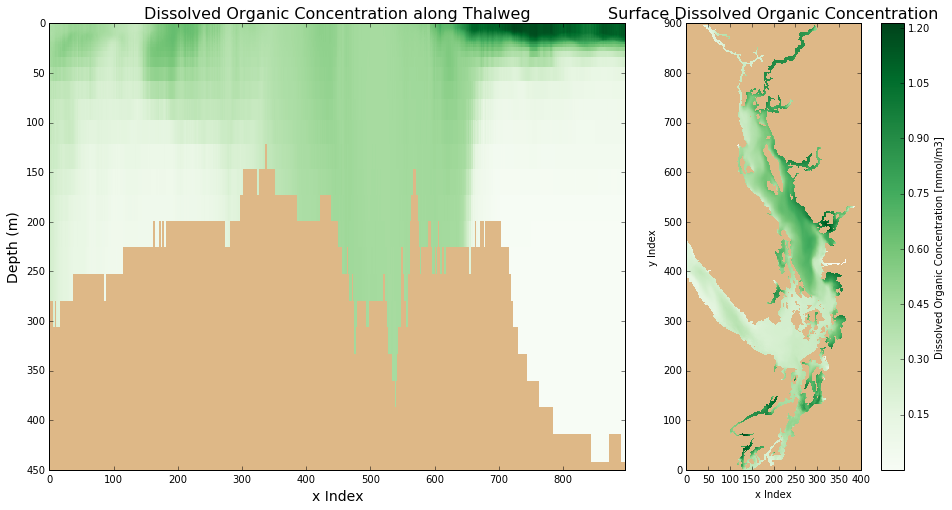

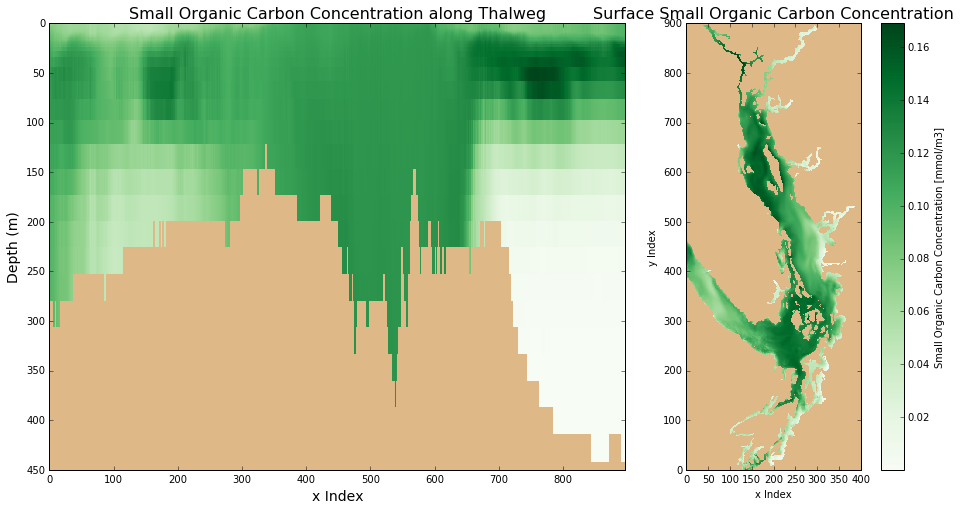

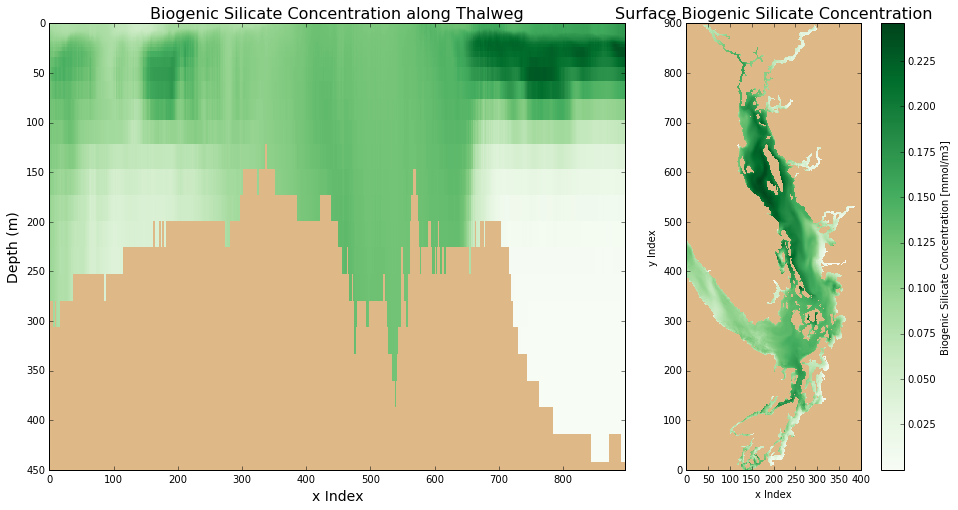

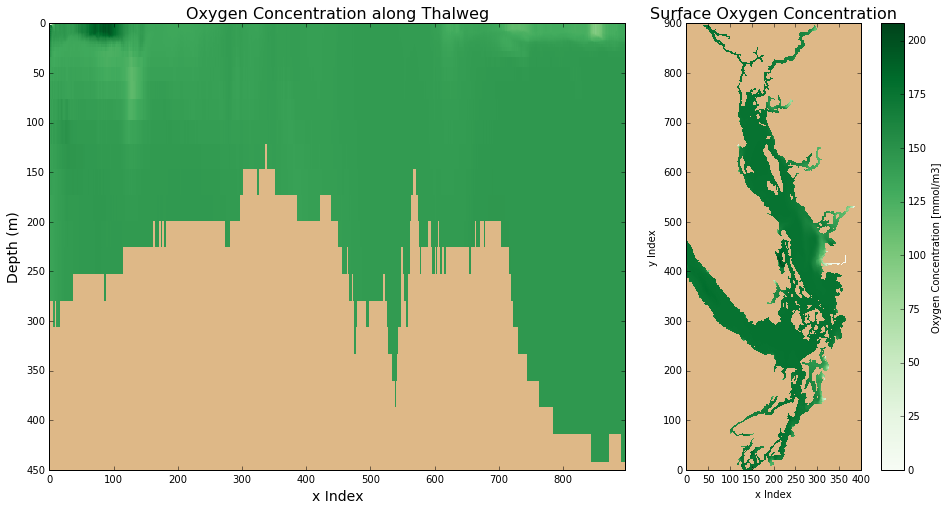

In [7]:
%%timeit -n1 -r1
#var = ('NO3', 'NH4', 'Si', 'PHY', 'PHY2', 'MYRI', 'MICZ', 'DOC', 'POC', 'bSi', 'O2')
for field in vnames:
    plot_surface_thalweg(grid_g, thalweg, x, z, field)